<a href="https://colab.research.google.com/github/dejanbatanjac/pytorch-learning-101/blob/master/WD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

0it [00:00, ?it/s]

9920512it [00:01, 9490698.69it/s]                            


Extracting /data/mnist/MNIST/raw/train-images-idx3-ubyte.gz


  0%|          | 0/28881 [00:00<?, ?it/s]

32768it [00:00, 136734.77it/s]           
  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting /data/mnist/MNIST/raw/train-labels-idx1-ubyte.gz


1654784it [00:00, 2237271.47it/s]                            
0it [00:00, ?it/s]

Extracting /data/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz


8192it [00:00, 53198.50it/s]            


Extracting /data/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz
Processing...
Done!
Epoch 0
Color: black
Train loss: 0.46914794568515494
Validation loss: 0.30531654162686084
Epoch 0
Color: cyan
Train loss: 0.8399506341618346
Validation loss: 0.7450754227517526


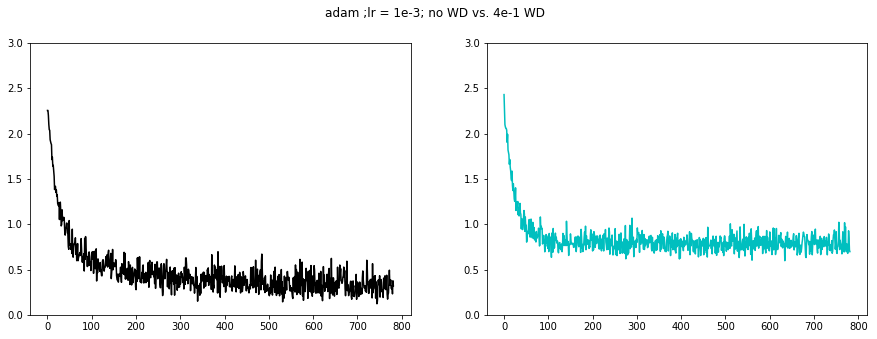

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, TensorDataset
from torch.optim import *
import torchvision
import matplotlib.pyplot as plt

dl = DataLoader( torchvision.datasets.MNIST('/data/mnist', train=True, download=True), shuffle=False)

tensor = dl.dataset.data
tensor = tensor.to(dtype=torch.float32)
tr = tensor.reshape(tensor.size(0), -1) 
tr = tr/128 # tr = tr/255
targets = dl.dataset.targets
targets = targets.to(dtype=torch.long)

x_train = tr[0:50000-1]
y_train = targets[0:50000-1]
x_valid = tr[50000:60000-1]
y_valid = targets[50000:60000-1]

bs=64

train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size=bs, drop_last=False, shuffle=True)

valid_ds = TensorDataset(x_valid, y_valid)
valid_dl = DataLoader(valid_ds, batch_size=bs * 2)

loaders={}
loaders['train'] = train_dl
loaders['valid'] = valid_dl


class M(nn.Module):
    'custom module'
    def __init__(self):
        super().__init__()
        self.lin = nn.Linear(784, 10)
      
    def forward(self, xb):
        return self.lin(xb)

    
colors = { "b": "blue", "g": "green",  "r": "red", "c": "cyan", "m": "magenta", "y": "yellow", "k": "black", "w": "white" }


def probe(ax, model, criterion, optimizer, bs, epochs, lr, wd_factor, color):
    
    losses=[]
    for epoch in range(0,epochs):
        train_loss = 0
        valid_loss = 0    
        print(f"Epoch {epoch}")

        model.train()
        for i, (data,target) in enumerate(loaders['train']):                
            optimizer.zero_grad()
            output = model(data)
            wd = 0.
            for p in model.parameters(): 
                wd += (p**2).sum()

            loss = criterion(output, target)+wd*wd_factor 
            train_loss += loss.item()
            loss.backward()            
            optimizer.step()
            if (i%1==0):
                #print(f"Batch {i}, loss {loss.item()}")
                losses.append(loss.item())

        model.eval()
        for i, (data,target) in enumerate(loaders['valid']):                
            output = model(data)
            loss = criterion(output,target)
            valid_loss += loss.item()        

        train_loss = train_loss/len(loaders['train'])
        valid_loss = valid_loss/len(loaders['valid'])        


        c = colors[color]
        print(f"Color: {c}") 
        print(f"Train loss: {train_loss}")
        print(f"Validation loss: {valid_loss}")
       
        
        ax.plot(losses, color)
        

    


fig, ax = plt.subplots(1, 2)
for _ in ax:
    _.set_ylim(0,3)

fig.suptitle('adam ;lr = 1e-3; no WD vs. 4e-1 WD')
fig.set_figheight(5)
fig.set_figwidth(15)



criterion = nn.CrossEntropyLoss()
bs=64
epochs = 1
wd_factor = 0.0


lr = 1e-3
wd_factor=0
model = M()
optimizer = torch.optim.Adam(model.parameters(), lr=lr,  weight_decay=0 )
probe(ax[0], model, criterion, optimizer, bs, epochs, lr, wd_factor, "k") #black


lr = 1e-3
wd_factor=0
model = M()
optimizer = torch.optim.Adam(model.parameters(), lr=lr,  weight_decay=4e-1 )
probe(ax[1], model, criterion, optimizer, bs, epochs, lr, wd_factor, "c") #cyan